In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from scipy.stats import lognorm
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

In [2]:
data = pd.read_hdf(r"E:\NTS\analysis\int\mode_3.h5", key='encoded')
simple_ind = pd.read_hdf(r"E:\NTS\analysis\int\mode_3.h5", key='unencoded')
cb = pd.read_hdf(r"E:\NTS\analysis\int\data.h5", key='3')

In [6]:
    def _tld_ml_prep(self, cb, seg_cols, dis_col, threshold=300):
        update = {}
        for i, j in self.luk.dct_to_specs(self.luk.set_01id).items():
            for k in j:
                if isinstance(k, str):
                    update[k.upper()] = i
                else:
                    update[k] = i
        update = pd.DataFrame.from_dict(update, orient="index", columns=["at"])
        modes = {}
        for mode in cb["mode"].unique():
            inner = cb[cb["mode"] == mode]
            dists = inner[dis_col].values
            bands = fun.dist_band(dists.max())
            inner["band"] = pd.cut(dists, bands)
            modes[mode] = inner
            inner_df = pd.merge(
                inner, update, left_on="settlement2011ew_b01id", right_index=True
            )
            inner_df.drop(columns=["band"]).to_hdf(
                r"E:\NTS\analysis\int\data.h5", key=str(mode), mode="a"
            )
            inner_df["count"] = 1
            seg_cols += ["at", "triporiggor_b02id"]
            big_count = inner_df.groupby(seg_cols)[["count", "trips"]].sum()
            small_count = (
                inner_df.groupby(seg_cols + ["band"], observed=False)["trips"]
                .sum()
                .reset_index(level="band")
            )
            big_count.columns = ["sample size", "agg trips"]
            joined = small_count.join(big_count, how="inner")
            joined["norm_trips"] = joined["trips"] / joined["agg trips"]
            joined["band start"] = pd.IntervalIndex(joined["band"]).left
            joined.set_index("band start", append=True, inplace=True)
            joined.reset_index(level="mode", inplace=True)
            joined.drop(["mode", "band"], axis=1, inplace=True)
            joined.drop(0, inplace=True)
            joined.drop([0, 5, 6], level="period", inplace=True)
            enc = OneHotEncoder()
            enc.fit(joined.index.to_frame())
            cols = []
            iterator = joined.index.names
            for i, cat in enumerate(enc.categories_):
                for j in cat:
                    cols.append(f"{iterator[i]}_{j}")
            index = enc.transform(joined.index.to_frame()).toarray()
            encoded_index = pd.MultiIndex.from_frame(pd.DataFrame(index, columns=cols))
            ready_data = pd.DataFrame(
                joined[["norm_trips", "sample size"]].values,
                index=encoded_index,
                columns=["norm_trips", "sample size"],
            )
            training = ready_data.loc[
                ready_data["sample size"] > threshold, "norm_trips"
            ]
            to_predict = ready_data.loc[
                ready_data["sample size"] <= threshold, "norm_trips"
            ]
            X = training.index.to_frame()
            y = training.values
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            regr = RandomForestRegressor()
            score = cross_validate(regr, X, y, cv=5, scoring=("r2"))
            regr.fit(X_train, y_train)
            test = regr.predict(X_test)
            pred = regr.predict(to_predict.index.to_frame())

        return ready_data

Index(['householdid', 'individualid', 'dayid', 'tripid', 'mainmode_b11id',
       'trippurpfrom_b01id', 'trippurpto_b01id', 'tripstart_b01id',
       'tripend_b01id', 'tripdisincsw', 'triptravtime', 'triporigcounty_b01id',
       'triporiggor_b02id', 'tripdestcounty_b01id', 'tripdestgor_b02id',
       'triporigareatype1_b01id', 'tripdestareatype1_b01id',
       'triporigareatype2_b01id', 'tripdestareatype2_b01id',
       'triporigua1998_b01id', 'triporigua2009_b01id', 'tripdestua1998_b01id',
       'tripdestua2009_b01id', 'w5', 'w5xhh', 'jjxsc', 'trippurpose_b01id',
       'surveyyear', 'hholdoslaua_b01id', 'hholdcounty_b01id',
       'hholdgor_b02id', 'settlement2011ew_b01id', 'hholdareatype1_b01id',
       'hholdareatype2_b01id', 'hholdua1998_b01id', 'hholdua2009_b01id',
       'hholdnumadults', 'hholdnumchildren', 'numcarvan', 'hhincome2002_b01id',
       'w1', 'w2', 'w3', 'age_b01id', 'sex_b01id', 'ecostat_b01id',
       'sic1992_b02id', 'sic2007_b02id', 'xsoc2000_b02id', 'nssec_b0

In [10]:
cb.set_index(['purpose', 'mode','at', 'triporiggor_b02id'], inplace=True)


In [7]:
counted = cb.groupby(['direction','mode','purpose','at','triporiggor_b02id'])['trips'].count()

In [13]:
cb.set_index(['direction','mode','purpose','at','triporiggor_b02id'], inplace=True)

In [37]:
city_1_8 = cb.loc['hb_fr', 3, 1,'city',8]

C:\Users\Predator\AppData\Local\Temp\ipykernel_14732\3018297182.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  city_1_8 = cb.loc['hb_fr', 3, 1,'city',8]


In [39]:
popt = lognorm.fit(city_1_8['trav_dist'])

In [20]:
major_7_7.groupby('trav_dist')['trips'].sum()

trav_dist
0.160930      39.620299
0.177023       1.056252
0.321860      50.753408
0.402325      66.651000
0.450604       1.289431
                ...    
481.180700     2.795046
492.445800     0.827332
502.101600     1.798901
537.988990     2.991534
772.464000     4.395958
Name: trips, Length: 580, dtype: float64

In [58]:
popt, pcov = curve_fit(grav_func, city_1_8.index, city_1_8.values, p0=(1, 1))

c:\Users\Predator\miniforge3\envs\NTS\lib\site-packages\pandas\core\indexes\base.py:911: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


In [59]:
popt

array([-7.18418002,  1.17424924])

In [28]:
popt

array([3.38407504e-04, 1.14077261e+00, 4.68538187e-01])

In [61]:
x = np.linspace(0, city_1_8.index.max(), len(city_1_8))
pdf_fitted = grav_func(x, *popt)

In [75]:
# residuals = major_7_7['trips'] - pdf_fitted
rss = np.sum(residuals**2)

In [76]:
rmse = np.sqrt(np.mean(residuals**2))
total_sum_of_squares = np.sum((weights - np.mean(weights))**2)
# explained_sum_of_squares = np.sum((lognormal_pdf(distance, *popt) - np.mean(weights))**2)
r_squared = 1 - (rss / total_sum_of_squares)

In [55]:
city_1_8

trav_dist
0.160930       37.137558
0.305767        1.689021
0.321860        7.397898
0.402325       56.175414
0.482790      118.204545
                 ...    
289.674000      1.536250
296.111200      1.218589
374.966900      1.131421
378.185500      3.347615
780.510500      1.213257
Name: trips, Length: 503, dtype: float64

In [54]:
city_1_8_grouped = city_1_8.groupby(['trav_dist'])['trips'].sum()

KeyError: 'Column not found: trips'

In [42]:
df = pd.DataFrame({'dist':x, 'weight':pdf_fitted})

In [52]:
city_1_8 = city_1_8.groupby('trav_dist')['trips'].sum()

In [57]:
def grav_func(x, n, b):
    return x**-n * np.exp(-b * x)

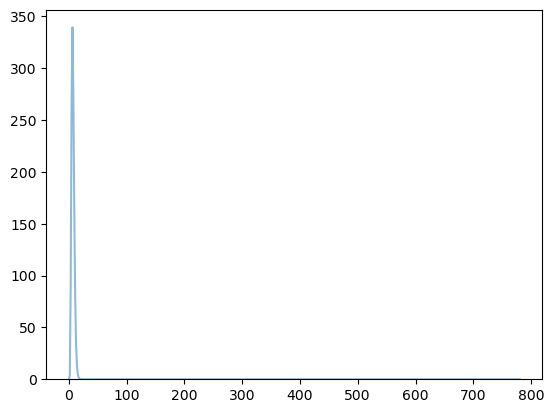

In [63]:
plt.hist(city_1_8.index, bins=500, density=True, alpha=0.6, color='g')
plt.plot(x, pdf_fitted, alpha=0.5)

In [109]:
df[df['fit']>0.1]

,dist,fit
67,1.567861,0.483469
68,1.591262,0.821266
69,1.614663,0.927033
70,1.638064,0.951495
71,1.661465,0.941963
...,...,...
155,3.627141,0.107756
156,3.650542,0.106103
157,3.673943,0.104488
158,3.697344,0.102909


In [110]:
df['dist'].max()

772.4639999999999

In [113]:
df['bin'] = pd.cut(df['dist'], 773)

In [114]:
major_7_7['bin'] = pd.cut(major_7_7['trav_dist'], 773)

C:\Users\Predator\AppData\Local\Temp\ipykernel_14188\3922497875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_7_7['bin'] = pd.cut(major_7_7['trav_dist'], 773)


In [117]:
major_grouped = major_7_7.groupby('bin')['trips'].sum()

In [118]:
df_grouped = df.groupby('bin')['fit'].sum()

In [120]:
df_grouped.index = major_grouped.index

In [124]:
joined = df_grouped.to_frame().join(major_grouped)

In [126]:
joined['trips'] *= joined['fit'].sum() / joined['trips'].sum()

In [135]:
residual = (joined['fit'] - joined['trips']).values

In [137]:
rss = np.sum(residuals**2)
rmse = np.sqrt(np.mean(residuals**2))



In [144]:
joined.reset_index(inplace=True)

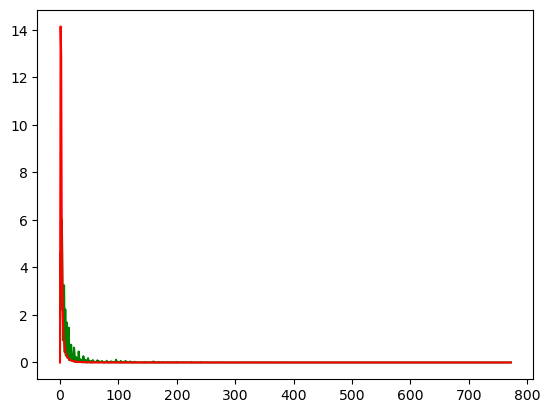

In [145]:
plt.plot(joined.index, joined['trips'], color='g')
plt.plot(joined.index, joined['fit'], color='r')

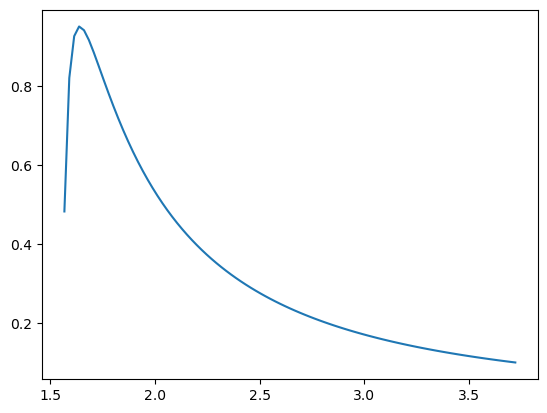

In [107]:
plt.plot(df[df['fit']>0.1]['dist'], df[df['fit']>0.1]['fit'])


In [42]:
np.sqrt(np.diag(pcov))

array([0.21186291, 0.0751672 , 0.08305514])

In [6]:
car.drop([0,5,6], level='period', inplace=True)

In [8]:
car.drop([1,2,3,6,7,8,9,10,11], level='triporiggor_b02id')

trips  \
purpose direction period at      triporiggor_b02id band start                
1       hb_fr     1      city    4                 0            165.343932   
                                                   1           1977.595132   
                                                   4           2802.800124   
                                                   9           1196.464327   
                                                   14          1090.731469   
...                                                                    ...   
8       nhb       4      village 5                 941            0.000000   
                                                   1005           0.000000   
                                                   1071           0.000000   
                                                   1140           0.000000   
                                                   1210           0.000000   

                                                               sample size  \
purpose direction period at      triporiggor_b02id band start                
1       hb_fr     1      city    4                 0                  8136   
                                                   1                  8136   
                                                   4                  8136   
                                                   9                  8136   
                                                   14                 8136   
...                                                                    ...   
8       nhb       4      village 5                 941                  19   
                                                   1005                 19   
                                                   1071                 19   
                                                   1140                 19   
                                                   1210                 19   

                                                                 agg trips  \
purpose direction period at      triporiggor_b02id band start                
1       hb_fr     1      city    4                 0           9193.188473   
                                                   1           9193.188473   
                                                   4           9193.188473   
                                                   9           9193.188473   
                                                   14          9193.188473   
...                                                                    ...   
8       nhb       4      village 5                 941           17.327568   
                                                   1005          17.327568   
                                                   1071          17.327568   
                                                   1140          17.327568   
                                                   1210          17.327568   

                                                               norm_trips  
purpose direction period at      triporiggor_b02id band start              
1       hb_fr     1      city    4                 0             0.017985  
                                                   1             0.215115  
                                                   4             0.304878  
                                                   9             0.130147  
                                                   14            0.118646  
...                                                                   ...  
8       nhb       4      village 5                 941           0.000000  
                                                   1005          0.000000  
                                                   1071          0.000000  
                                                   1140          0.000000  
                                                   1210          0.000000  

[34040 rows x 4 columns]

In [42]:
no_tp = car.groupby(level=['purpose', 'direction', 'at', 'triporiggor_b02id', 'band']).sum()

In [43]:
no_tp['norm_trips'] = no_tp['count']

count  agg_count  norm_trips
purpose direction at      triporiggor_b02id band                              
1       hb_fr     city    1                 0        74       6043    0.119826
                                            1      1276       6043    1.668411
                                            4      1590       6043    2.091064
                                            9      1015       6043    1.121087
                                            14      982       6043    0.921827
...                                                 ...        ...         ...
8       nhb       village 11                941       0        825    0.000000
                                            1005      0        825    0.000000
                                            1071      0        825    0.000000
                                            1140      0        825    0.000000
                                            1210      0        825    0.000000

[46694 rows x 3 columns]

In [14]:
training = data.loc[data['sample size'] > 200, 'norm_trips']
to_predict = data.loc[data['sample size'] <= 200, 'norm_trips']
X = training.index.to_frame()
y = training.values
X_train, X_test, y_train, y_test = train_test_split(X, y)
regr = RandomForestRegressor()

In [15]:
score = cross_validate(regr, X, y, cv=5, scoring=("r2"))

In [18]:
regr.fit(X, y)

RandomForestRegressor()

In [19]:

pred = regr.predict(to_predict.index.to_frame())

In [26]:
clean_to_pred = simple_ind[simple_ind['sample size'] <= 200]

In [28]:
clean_to_pred['predicted_trips'] = pred

C:\Users\Predator\AppData\Local\Temp\ipykernel_4092\4261564238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_to_pred['predicted_trips'] = pred


In [30]:
to_predict = to_predict.to_frame()

In [36]:
to_predict['predicted'] = pred

In [37]:
to_predict

norm_trips  \
mode_1 mode_2 mode_3 mode_4 mode_5 mode_6 mode_7 mode_8 purpose_hb_fr purpose_hb_to purpose_nhb direction_1 direction_2 direction_3 direction_4 period_city period_major period_minor period_town period_village at_0 at_1 at_2 at_3 at_4 at_5 at_6 at_7 at_8 at_9 at_10 at_11 triporiggor_b02id_0 triporiggor_b02id_2 triporiggor_b02id_5 triporiggor_b02id_9 triporiggor_b02id_15 triporiggor_b02id_23 triporiggor_b02id_32 triporiggor_b02id_43 triporiggor_b02id_56 triporiggor_b02id_71 triporiggor_b02id_88 triporiggor_b02id_106 triporiggor_b02id_127 triporiggor_b02id_149 triporiggor_b02id_174 triporiggor_b02id_200 triporiggor_b02id_229 triporiggor_b02id_260 triporiggor_b02id_292 triporiggor_b02id_327 triporiggor_b02id_365 triporiggor_b02id_404 triporiggor_b02id_446 triporiggor_b02id_489 triporiggor_b02id_535 triporiggor_b02id_584 triporiggor_b02id_634 triporiggor_b02id_687 triporiggor_b02id_742 triporiggor_b02id_800 triporiggor_b02id_860 triporiggor_b02id_922              
1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0           0.0           0.0         1.0         0.0         0.0         0.0         1.0         0.0          0.0          0.0         0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   0.0   1.0                 0.0                 0.0                 0.0                 0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                     0.110546   
                                                                                                                                                                                                                                                                               0.0                 1.0                 0.0                 0.0                 0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                          0.0   
                                                                                                                                                                                                                                                                                                   0.0                 1.0                 0.0                 0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                  0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                   0.0                     0.287931   
                                                                                          

In [23]:
to_predict

mode_1    mode_2  mode_3  mode_4  mode_5  mode_6  mode_7  mode_8  purpose_hb_fr  purpose_hb_to  purpose_nhb  direction_1  direction_2  direction_3  direction_4  period_city  period_major  period_minor  period_town  period_village  at_0  at_1  at_2  at_3  at_4  at_5  at_6  at_7  at_8  at_9  at_10  at_11  triporiggor_b02id_0  triporiggor_b02id_2  triporiggor_b02id_5  triporiggor_b02id_9  triporiggor_b02id_15  triporiggor_b02id_23  triporiggor_b02id_32  triporiggor_b02id_43  triporiggor_b02id_56  triporiggor_b02id_71  triporiggor_b02id_88  triporiggor_b02id_106  triporiggor_b02id_127  triporiggor_b02id_149  triporiggor_b02id_174  triporiggor_b02id_200  triporiggor_b02id_229  triporiggor_b02id_260  triporiggor_b02id_292  triporiggor_b02id_327  triporiggor_b02id_365  triporiggor_b02id_404  triporiggor_b02id_446  triporiggor_b02id_489  triporiggor_b02id_535  triporiggor_b02id_584  triporiggor_b02id_634  triporiggor_b02id_687  triporiggor_b02id_742  triporiggor_b02id_800  triporiggor_b02id_86

In [19]:
data.to_hdf(r"E:\NTS\analysis\int\test.h5", key='None', complevel=3)

c:\Users\Predator\anaconda3\envs\NTS\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is a Python keyword: 'None'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\Predator\anaconda3\envs\NTS\lib\site-packages\tables\attributeset.py:457: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_nameband_(0, 1]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Users\Predator\anaconda3\envs\NTS\lib\site-packages\tables\attributeset.py:457: NaturalNameWarning: object name is not a valid Python identifier: 'axis1_nameband_(1, 4]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_

In [7]:
score['test_score'].mean()

0.7423008001964295